  2%|▏         | 1/50 [00:13<11:07, 13.63s/it]

Epoch: 1 | Train loss: 0.519 | Train accuracy: 0.81 | Test loss: 0.386 | Test accuracy: 0.85


  4%|▍         | 2/50 [00:27<10:50, 13.55s/it]

Epoch: 2 | Train loss: 0.326 | Train accuracy: 0.88 | Test loss: 0.327 | Test accuracy: 0.88


  6%|▌         | 3/50 [00:41<11:04, 14.13s/it]

Epoch: 3 | Train loss: 0.283 | Train accuracy: 0.90 | Test loss: 0.291 | Test accuracy: 0.89


  8%|▊         | 4/50 [00:56<10:50, 14.15s/it]

Epoch: 4 | Train loss: 0.256 | Train accuracy: 0.91 | Test loss: 0.288 | Test accuracy: 0.90


 10%|█         | 5/50 [01:11<10:48, 14.42s/it]

Epoch: 5 | Train loss: 0.235 | Train accuracy: 0.91 | Test loss: 0.282 | Test accuracy: 0.90


 12%|█▏        | 6/50 [01:25<10:28, 14.28s/it]

Epoch: 6 | Train loss: 0.219 | Train accuracy: 0.92 | Test loss: 0.262 | Test accuracy: 0.90


 14%|█▍        | 7/50 [01:39<10:13, 14.27s/it]

Epoch: 7 | Train loss: 0.205 | Train accuracy: 0.92 | Test loss: 0.244 | Test accuracy: 0.91


 16%|█▌        | 8/50 [01:54<10:09, 14.52s/it]

Epoch: 8 | Train loss: 0.194 | Train accuracy: 0.93 | Test loss: 0.250 | Test accuracy: 0.91
No improvement for 1 epochs...


 18%|█▊        | 9/50 [02:08<09:55, 14.52s/it]

Epoch: 9 | Train loss: 0.182 | Train accuracy: 0.93 | Test loss: 0.237 | Test accuracy: 0.91


 20%|██        | 10/50 [02:21<09:20, 14.01s/it]

Epoch: 10 | Train loss: 0.173 | Train accuracy: 0.94 | Test loss: 0.243 | Test accuracy: 0.91
No improvement for 1 epochs...


 22%|██▏       | 11/50 [02:34<08:56, 13.77s/it]

Epoch: 11 | Train loss: 0.165 | Train accuracy: 0.94 | Test loss: 0.241 | Test accuracy: 0.92
No improvement for 2 epochs...


 22%|██▏       | 11/50 [02:47<09:55, 15.27s/it]


Epoch: 12 | Train loss: 0.157 | Train accuracy: 0.94 | Test loss: 0.249 | Test accuracy: 0.92
No improvement for 3 epochs...
Early stopping triggered.


100%|██████████| 313/313 [00:00<00:00, 340.85it/s]


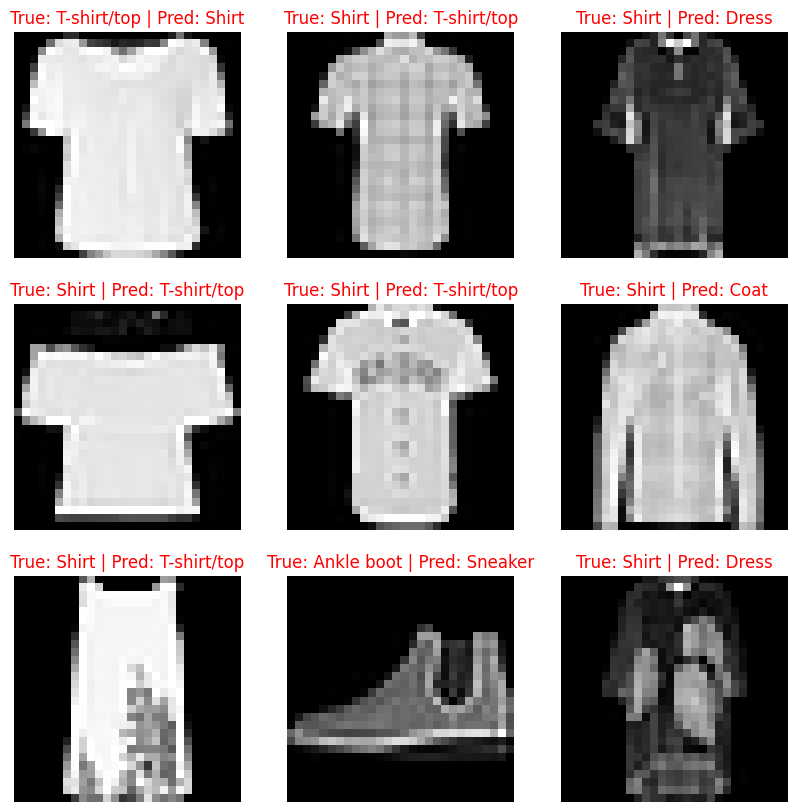

In [2]:
# Import required libraries
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch
from torchmetrics import Accuracy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np

# Download FashionMNIST datasets
fashion_train = datasets.FashionMNIST(root=".",
                                       download=True,
                                       train=True,
                                       transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST(root=".",
                                      train=False,
                                      download=True,
                                      transform=transforms.ToTensor())

# Get class names
class_labels = fashion_train.classes

# Create DataLoaders
train_loader = DataLoader(fashion_train, batch_size=32, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=32, shuffle=False)

# Define the enhanced model
class CustomFashionModel(nn.Module):
    def __init__(self, input_channels: int, feature_maps: int, output_classes: int): 
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=feature_maps, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=feature_maps, out_channels=feature_maps, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=feature_maps, out_channels=feature_maps * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=feature_maps * 2, out_channels=feature_maps * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=feature_maps * 2, out_channels=feature_maps * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=feature_maps * 2 * 3 * 3, out_features=output_classes)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x

# Initialize the model, loss, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomFashionModel(input_channels=1, feature_maps=16, output_classes=10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
early_stopping_patience = 3
min_validation_loss = float('inf')
epochs_without_improvement = 0

# Training and evaluation loop
epochs = 50  # Set higher to allow early stopping to take effect
accuracy_metric = Accuracy(task='multiclass', num_classes=len(class_labels)).to(device)

for epoch in tqdm(range(epochs)):
    train_loss_total, test_loss_total = 0, 0
    train_accuracy, test_accuracy = 0, 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        loss = loss_function(predictions, labels)
        train_loss_total += loss
        train_accuracy += accuracy_metric(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_total /= len(train_loader)
    train_accuracy /= len(train_loader)

    # Evaluation loop
    model.eval()
    with torch.inference_mode():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_predictions = model(test_images)
            test_loss = loss_function(test_predictions, test_labels)
            test_loss_total += test_loss
            test_accuracy += accuracy_metric(test_predictions, test_labels)

        test_loss_total /= len(test_loader)
        test_accuracy /= len(test_loader)

    print(f"Epoch: {epoch + 1} | Train loss: {train_loss_total:.3f} | "
          f"Train accuracy: {train_accuracy:.2f} | Test loss: {test_loss_total:.3f} | "
          f"Test accuracy: {test_accuracy:.2f}")

    # Early stopping check
    if test_loss_total < min_validation_loss:
        min_validation_loss = test_loss_total
        epochs_without_improvement = 0  # Reset the counter if improvement
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs...")

    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Evaluate wrong predictions
all_predictions = []
model.eval()
with torch.inference_mode():
    for test_images, test_labels in tqdm(test_loader):
        pred_logits = model(test_images.to(device))
        pred_classes = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)
        all_predictions.append(pred_classes)
all_predictions = torch.cat(all_predictions).cpu()

# Analyze incorrect predictions
mismatched_indices = np.where(all_predictions != fashion_test.targets)[0]
random_samples = random.sample(list(mismatched_indices), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_samples):
    true_label = class_labels[fashion_test[idx][1]]
    predicted_label = class_labels[all_predictions[idx]]
    plt.subplot(3, 3, i + 1)
    plt.imshow(fashion_test[idx][0].squeeze(), cmap="gray")
    plt.title(f"True: {true_label} | Pred: {predicted_label}", color="red")
    plt.axis(False)
plt.show()
